# Lego Parts in Sets over Time

Requirements to run as-is:
* Google Colab and Google Drive
* Drive folder `/lego`
* Folder `/lego` contains Rebrickable [downloads](https://rebrickable.com/downloads/)
* Folder `/lego` contains a Rebrickable [API](https://rebrickable.com/api/v3/docs/) Key in the file `rbl`



# Get Data

## Google Drive

In [1]:
UPLOAD_FOLDER = 'My Drive/lego/'
CACHE_FOLDER = 'cache/'

GDRIVE_ROOT = '/content/gdrive/'
FS_ROOT = GDRIVE_ROOT + UPLOAD_FOLDER
RAW_ROOT = FS_ROOT
CACHE_DIR = RAW_ROOT + CACHE_FOLDER

from google.colab import drive
drive.mount(GDRIVE_ROOT)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

def get_df(fname):
  return pd.read_csv(RAW_ROOT + fname)

# Rebrickable downloads
parts_df = get_df('parts.csv').set_index('part_num')
sets_df = get_df('sets.csv').set_index('set_num')
inventories_df = get_df('inventories.csv').set_index('id')
inventory_parts_df = get_df('inventory_parts.csv')
colors_df = get_df('colors.csv').set_index('id')
minifigs_df = get_df('minifigs.csv').set_index('fig_num')

## Rebrickable API & Drive Cache

In [3]:
import requests

RBL_HOST = 'https://rebrickable.com'
RBL_ROOT = '/api/v3/lego/'
RBL_PRE = RBL_HOST + RBL_ROOT

key_file = open(RAW_ROOT + 'rbl', 'r')
rbl_api_key = key_file.readlines()[0].strip()
auth_value = 'key ' + rbl_api_key
RBL_HDR = {'Authorization': auth_value }

def get_rbl_uri(uri):
  return requests.get(uri, headers=RBL_HDR).json()

def get_part_details(part_num):
  return requests.get(RBL_PRE + f'parts/{part_num}', headers=RBL_HDR).json()

def get_part_list_details(part_nums):
  part_nums_param_val = ','.join([str(p) for p in part_nums])
  other_params = '&inc_part_details=1&page_size=1000'
  uri = RBL_PRE + f'parts/?part_nums={part_nums_param_val}' + other_params
  return requests.get(uri, headers=RBL_HDR).json()

In [4]:
import glob
import json
import time

def write_part_results(results, page_num):
  Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)
  results_file_name = CACHE_DIR + f'results_page_{page_num:03d}.json'
  with open(results_file_name, 'w') as outfile:
    json.dump(results, outfile)

def cache_all_parts(max_pages=100):
  page_index = 0
  page_response = get_part_list_details([])
  while page_response['next'] is not None and page_index < max_pages:
    print(f'caching results page {page_index}')
    write_part_results(page_response['results'], page_index)
    page_index = page_index + 1
    # be nice to Rebrickable API
    time.sleep(10)
    page_response = get_rbl_uri(page_response['next'])

cache_exists = len(glob.glob(CACHE_DIR + '*.json')) > 0
if not cache_exists:
  cache_all_parts()
else:
  print('cache exists')

cache exists


In [5]:
def build_cache_index():
  dir_list = sorted(glob.glob(CACHE_DIR + '*.json'))
  json_cache = []
  for f in dir_list:
    with open(f) as json_file:
      data = json.load(json_file)
      json_cache = json_cache + data
  return {p['part_num'] : p for p in json_cache}

# Set Up Data Structures

In [6]:
def get_sets_by_part():
  sbp = {}
  sbp_q = {}
  for _, ip in inventory_parts_df.iterrows():
    pn = ip['part_num']
    if pn not in sbp.keys():
      sbp[pn] = set()
      sbp_q[pn] = {}
    inv_id = ip['inventory_id']
    set_num = inventories_df.loc[inv_id, 'set_num']
    sbp[pn].add(set_num)
    if set_num not in sbp_q[pn].keys():
      sbp_q[pn][set_num] = 0
    sbp_q[pn][set_num] = sbp_q[pn][set_num] + ip['quantity']
  return sbp, sbp_q

In [7]:
!pip install jsonpickle
import jsonpickle

sbp_cache = RAW_ROOT + 'sbp.json'
sbp_q_cache = RAW_ROOT + 'sbp_q.json'
sets_by_part = {}
sets_by_part_quantities = {}

if Path(sbp_cache).is_file() and Path(sbp_q_cache).is_file():
  print('reading from sets by part cache')
  with open(sbp_cache) as infile:
    json_serialised = json.load(infile)
    sets_by_part = jsonpickle.decode(json_serialised)
  with open(sbp_q_cache) as infile:
    json_serialised = json.load(infile)
    sets_by_part_quantities = jsonpickle.decode(json_serialised)
else:
  print('caching sets by part')
  sets_by_part, sets_by_part_quantities = get_sets_by_part()
  with open(sbp_cache, 'w') as outfile:
    json_serialised = jsonpickle.encode(sets_by_part)
    json.dump(json_serialised, outfile)
  with open(sbp_q_cache, 'w') as outfile:
    json_serialised = jsonpickle.encode(sets_by_part_quantities)
    json.dump(json_serialised, outfile)

print(f'set lists indexed by {len(sets_by_part)} parts')

reading from sets by part cache
set lists indexed by 37942 parts


In [8]:
jcpn = build_cache_index()

# Inventory Parts Data

In [9]:
demo_part_num = '10190' # '3039'
inv_prt_demo_df = inventory_parts_df[inventory_parts_df['part_num'] == demo_part_num].sort_values(['quantity', 'color_id'])
inv_prt_demo_df.head()

,inventory_id,part_num,color_id,quantity,is_spare
703081,35060,10190,0,1,t
789749,56530,10190,0,1,f
51458,1630,10190,25,1,f
451956,14207,10190,25,1,t
539078,18411,10190,27,1,t


In [10]:
sets_from_inv = inventories_df.loc[inv_prt_demo_df['inventory_id'], 'set_num']
inv_prt_demo_df['set_id'] = list(sets_from_inv)

In [11]:
pv = inv_prt_demo_df.pivot_table(index='set_id', columns=['color_id', 'is_spare'], values='quantity', aggfunc='sum').fillna(0)
pv['total'] = pv.sum(axis=1)
pv.sort_values('total', ascending=False, inplace=True)
pv.drop(columns='total', inplace=True)

In [12]:
def color_string_from_id(color_id):
  return colors_df.loc[color_id, 'rgb']

def chart_color(color_id, is_spare):
  rgb = color_string_from_id(color_id)
  return '#' + rgb + ('66' if is_spare == 't' else '')

colors_demo = [chart_color(x[0], x[1]) for x in pv.columns]

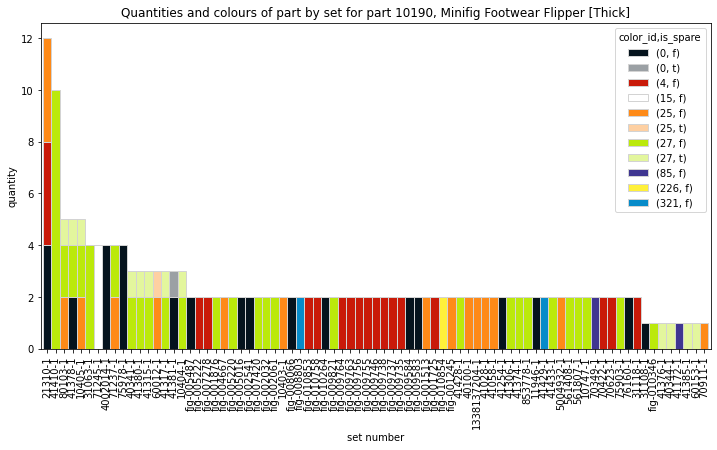

In [13]:
pv.plot.bar(stacked=True, color=colors_demo, figsize=(12, 6), width=1.0, edgecolor='lightgrey')
plt.title(f'Quantities and colours of part by set for part {demo_part_num}, {jcpn[demo_part_num]["name"]}')
# for small numbers
plt.ylabel('quantity')
plt.xlabel('set number')
# for big numbers
#plt.yscale('log')
#plt.axis('off')
#plt.legend().remove()
plt.show()

In [14]:
#spares
total_part_quantities = inventory_parts_df['quantity'].sum()
spare_part_quantities = inventory_parts_df[inventory_parts_df['is_spare'] == 't']['quantity'].sum()
print(f'{spare_part_quantities / total_part_quantities * 100:.0f}% of parts are spares')

2% of parts are spares


# Part Inclusion in Sets

In [15]:
counts_sbp = {p : len(v) for p, v in sets_by_part.items()}
counts_sbp_sorted = dict(sorted(counts_sbp.items(), key=lambda item: item[1], reverse=True))
part_set_counts = np.array(list(counts_sbp_sorted.values()))
part_ranks = np.array(range(len(part_set_counts))) + 1

quantities_sbp = {p : sum(v.values()) for p, v in sets_by_part_quantities.items()}
quantities_sbp_sorted = dict(sorted(quantities_sbp.items(), key=lambda item: item[1], reverse=True))
part_set_quantities = np.array(list(quantities_sbp_sorted.values()))
part_set_quantities_by_counts = [quantities_sbp[p] for p in counts_sbp_sorted.keys()]

In [16]:
import math
from scipy.optimize import curve_fit

log_ranks = np.log10(part_ranks)
log_counts = np.log10(part_set_counts)
log_quantities = np.log10(part_set_quantities)
log_quantities_by_counts = np.log10(part_set_quantities_by_counts)

def log_log_lin(x, m, c):
  return m * x + c

def two_piece_lin_fit(x, y, elbow):
  ps1, _ = curve_fit(log_log_lin, x[:elbow], y[:elbow])
  c1 = log_log_lin(x[:elbow], ps1[0], ps1[1])
  ps2, _ = curve_fit(log_log_lin, x[elbow:], y[elbow:])
  c2 = log_log_lin(x[elbow:], ps2[0], ps2[1])
  return ps1, c1, ps2, c2

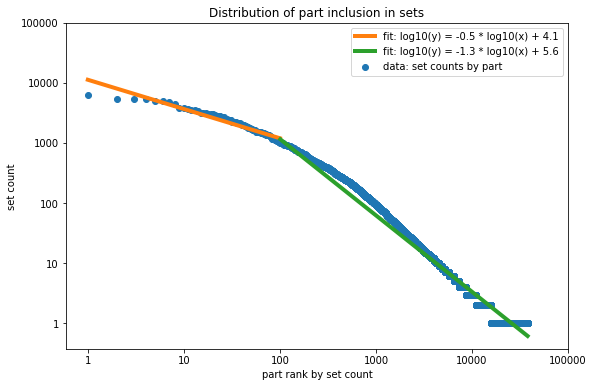

In [17]:
elbow = 100

counts_ps1, counts_c1, counts_ps2, counts_c2 = two_piece_lin_fit(log_ranks, log_counts, elbow)
quants_ps1, quants_c1, quants_ps2, quants_c2 = two_piece_lin_fit(log_ranks, log_quantities, elbow)

plt.figure(figsize=(9, 6))
plt.scatter(log_ranks, log_counts, color='tab:blue')
plt.plot(log_ranks[:elbow], counts_c1, color='tab:orange', lw=4)
plt.plot(log_ranks[elbow:], counts_c2, color='tab:green', lw=4)

#plt.scatter(log_ranks, log_quantities, color='tab:gray')
#plt.plot(log_ranks[:elbow], quants_c1, color='tab:olive', lw=4)
#plt.plot(log_ranks[elbow:], quants_c2, color='tab:cyan', lw=4)

plt.xlabel('part rank by set count')
plt.xticks(np.arange(0, 6), np.power(10, np.arange(0, 6)))
plt.ylabel('set count')
plt.yticks(np.arange(0, 6), np.power(10, np.arange(0, 6)))
plt.legend([f'fit: log10(y) = {counts_ps1[0]:.1f} * log10(x) + {counts_ps1[1]:.1f}',
            f'fit: log10(y) = {counts_ps2[0]:.1f} * log10(x) + {counts_ps2[1]:.1f}',
            #f'fit: log10(y) = {quants_ps1[0]:.1f} * log10(x) + {quants_ps1[1]:.1f}',
            #f'fit: log10(y) = {quants_ps2[0]:.1f} * log10(x) + {quants_ps2[1]:.1f}',
            'data: set counts by part'])
            #'data: part quantities in sets by part'])
plt.title('Distribution of part inclusion in sets')
plt.show()

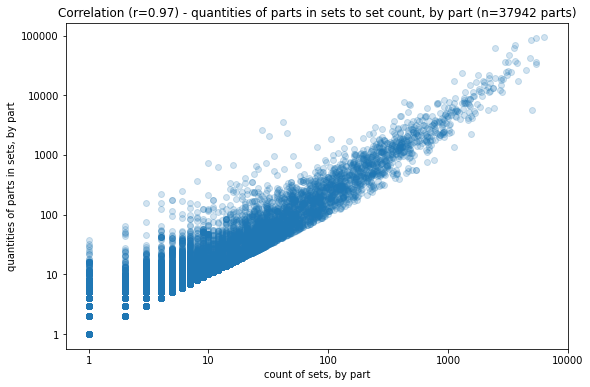

In [18]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(log_counts, log_quantities_by_counts)

plt.figure(figsize=(9, 6))
plt.scatter(log_counts, log_quantities_by_counts, alpha=0.2)
plt.xlabel('count of sets, by part')
plt.xticks(np.arange(0, 5), np.power(10, np.arange(0, 5)))
plt.ylabel('quantities of parts in sets, by part')
plt.yticks(np.arange(0, 6), np.power(10, np.arange(0, 6)))
plt.title(f'Correlation (r={r_value:0.2f}) - quantities of parts in sets to set count, by part (n={len(log_counts)} parts)')
plt.show()

In [19]:
one_set = np.argwhere(log_counts == 0).flatten()
quant_max = np.argmax(log_quantities_by_counts[one_set])
quant_max_part_index = one_set[quant_max]
prt_quant_max = list(counts_sbp_sorted.keys())[quant_max_part_index]
jcpn[prt_quant_max]

{'alternates': [],
 'external_ids': {'BrickOwl': ['340115']},
 'molds': ['27', '27c'],
 'name': 'Window 1 x 2 x 1 (old type) with Extended Lip',
 'part_cat_id': 16,
 'part_img_url': 'https://cdn.rebrickable.com/media/parts/ldraw/4/27b.png',
 'part_num': '27b',
 'part_url': 'https://rebrickable.com/parts/27b/window-1-x-2-x-1-old-type-with-extended-lip/',
 'print_of': None,
 'prints': [],
 'year_from': 1966,
 'year_to': 1966}

In [20]:
sets_df.loc[sets_by_part[prt_quant_max],:]

,name,year,theme_id,num_parts
set_num,,,,
458-1,"1 x 2 x 1 Window, Red or White",1966,371,19


In [21]:
parts_one_set = np.array(list(counts_sbp_sorted.keys()))[one_set]
sets_one_set = [list(sets_by_part[p])[0] for p in parts_one_set]
sets_sets = np.isin(sets_one_set, sets_df.index)
sets_minifigs = np.isin(sets_one_set, minifigs_df.index)

print(f'{len(sets_one_set)} sets in tail, {len(np.unique(sets_one_set))} are unique')
print(f'{sum(sets_sets)} sets listed as sets, {sum(sets_minifigs)} lists as minifigs')

22066 sets in tail, 10104 are unique
13302 sets listed as sets, 8764 lists as minifigs


# Part Reuse Instances

In [22]:
pc_1 = 100 * len(np.argwhere(part_set_counts == 1)) / len(part_set_counts)
pc_10 = 100 * len(np.argwhere(part_set_counts <= 10)) / len(part_set_counts)

print(f'{pc_1:.0f}% of parts appear in only 1 set')
print(f'{pc_10:.0f}% of parts appear in 10 sets or fewer')

58% of parts appear in only 1 set
89% of parts appear in 10 sets or fewer


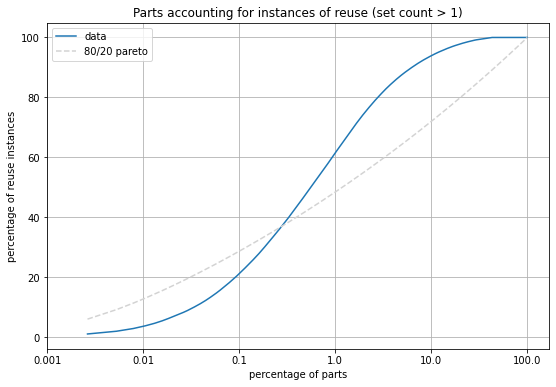

In [23]:
reuse_instances = part_set_counts - 1
cumulative_reuse = np.cumsum(reuse_instances)
cumulative_reuse_prop = cumulative_reuse / cumulative_reuse[-1]
log_part_rank_prop = np.log10(part_ranks / part_ranks[-1])

# compare to a pareto 80/20 distribution
pareto_set_counts = 12000 / np.power(part_ranks, 0.925) + 1
pareto_cumulative = np.cumsum(pareto_set_counts - 1)
cumulative_pareto_prop = pareto_cumulative / pareto_cumulative[-1]

plt.figure(figsize=(9, 6))
plt.plot(log_part_rank_prop, cumulative_reuse_prop * 100)
plt.plot(log_part_rank_prop, cumulative_pareto_prop * 100, linestyle='--', color='lightgrey')
plt.xticks(np.arange(-5, 1), np.power(10.0, np.arange(-5, 1)) * 100)
plt.ylabel('percentage of reuse instances')
plt.xlabel('percentage of parts')
plt.legend(['data', '80/20 pareto'])
plt.grid()
plt.title('Parts accounting for instances of reuse (set count > 1)')

plt.show()

In [24]:
def reuse_accounting(reuse_prop, thold_prop):
  thold_id = np.argwhere(reuse_prop > thold_prop)[0]
  return thold_id[0] / len(part_ranks)

for p in [0.8, 0.9, 0.95, 0.99]:
  print(f'{p * 100}% of reuse instances from {reuse_accounting(cumulative_reuse_prop, p) * 100:.0f}% of parts')

80.0% of reuse instances from 3% of parts
90.0% of reuse instances from 6% of parts
95.0% of reuse instances from 12% of parts
99.0% of reuse instances from 28% of parts


# Lifespans and Set Inclusions

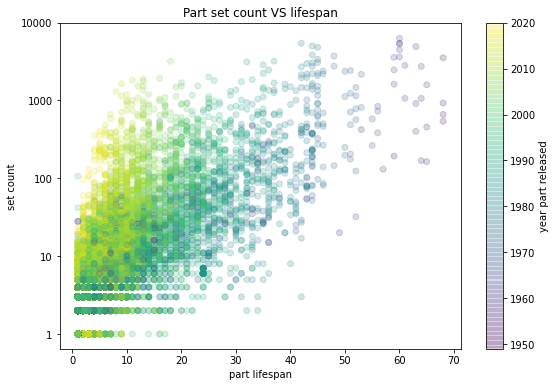

In [25]:
max_year = 2020
yrel_by_part = {p : v['year_from'] for p, v in jcpn.items()
                    if 0 < v['year_from'] <= max_year}
lifespan_by_part = {p : v['year_to'] + 1 - v['year_from'] for p, v in jcpn.items()
                    if 0 < v['year_from'] <= max_year}

min_key_set = set(lifespan_by_part.keys()).intersection(set(counts_sbp.keys()))
sorted_part_keys = sorted(min_key_set)
yrel_aligned = np.array([yrel_by_part[p] for p in sorted_part_keys])
lifespan_aligned = np.array([lifespan_by_part[p] for p in sorted_part_keys])
counts_sbp_aligned = np.array([counts_sbp[p] for p in sorted_part_keys])
log_counts_aligned = np.log10(counts_sbp_aligned)

plt.figure(figsize=(9, 6))
plt.scatter(lifespan_aligned, log_counts_aligned, c=yrel_aligned, alpha=0.2)
plt.colorbar(label='year part released')
plt.ylabel('set count')
plt.yticks(np.arange(0, 5), np.power(10, np.arange(0, 5)))
plt.xlabel('part lifespan')
plt.title('Part set count VS lifespan')
plt.show()

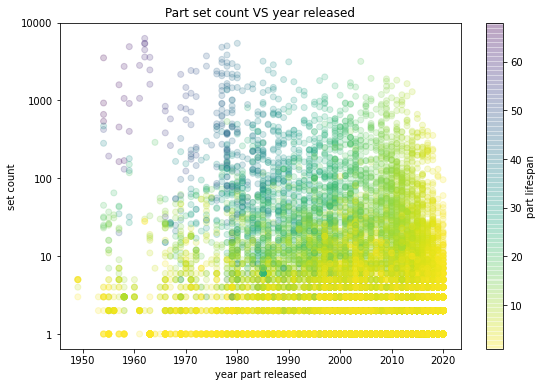

In [26]:
plt.figure(figsize=(9, 6))
plt.scatter(yrel_aligned, log_counts_aligned, c=lifespan_aligned, alpha=0.2, cmap='viridis_r')
plt.colorbar(label='part lifespan')
plt.ylabel('set count')
plt.yticks(np.arange(0, 5), np.power(10, np.arange(0, 5)))
plt.xlabel('year part released')
plt.title('Part set count VS year released')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


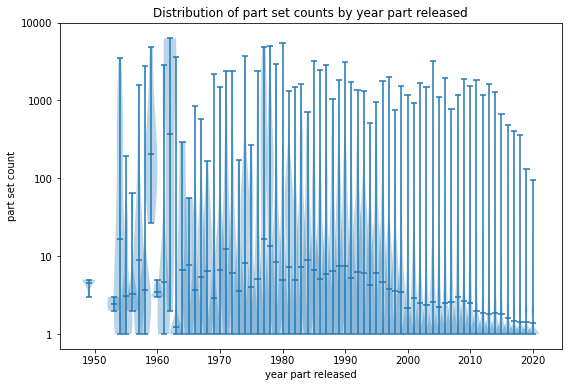

In [27]:
ypa = sorted(np.unique(yrel_aligned))
violinplot_sc = np.array([log_counts_aligned[np.nonzero(np.array(yrel_aligned) == yr)] for yr in ypa], dtype=object)

plt.figure(figsize=(9, 6))
plt.violinplot(violinplot_sc, ypa, widths=2, showmeans=True)
plt.yticks(np.arange(0, 5), np.power(10, np.arange(0, 5)))
plt.ylabel('part set count')
plt.xlabel('year part released')
plt.title('Distribution of part set counts by year part released')
plt.show()

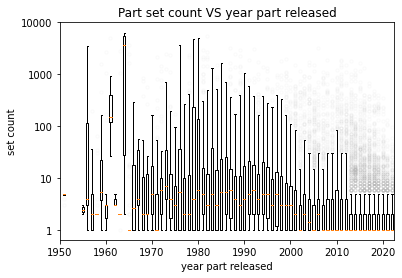

In [28]:
yrange = range(min(yrel_by_part.values()), max_year + 1)
boxplot_sc = np.array([log_counts_aligned[np.nonzero(np.array(yrel_aligned) == yr)] for yr in yrange], dtype=object)

plt.boxplot(boxplot_sc, flierprops={'markeredgecolor':'#bbb1', 'markersize':3})
plt.yticks(np.arange(0, 5), np.power(10, np.arange(0, 5)))
plt.xticks([10 * y for y in range(len(list(yrange[1::10])))], yrange[1::10])
plt.ylabel('set count')
plt.xlabel('year part released')
plt.title('Part set count VS year part released')
plt.show()

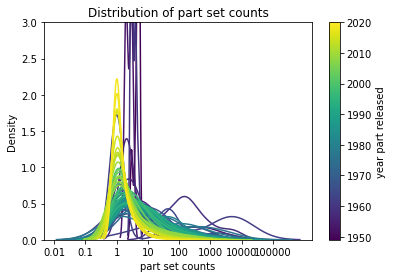

In [29]:
import seaborn as sb
import matplotlib as mpl

for i, bps in enumerate(boxplot_sc):
  sb.kdeplot(bps, bw_method=0.5, color=mpl.cm.viridis(i / len(boxplot_sc)), alpha=0.5)
plt.ylim((0,3))
plt.xticks(range(-2, 6), [int(math.pow(10, y)) if y >= 0 else math.pow(10, y) for y in range(-2, 6)])
plt.title('Distribution of part set counts')
plt.xlabel('part set counts')
yr_norm = mpl.colors.Normalize(vmin=min(yrange), vmax=max(yrange))
plt.colorbar(mpl.cm.ScalarMappable(norm=yr_norm, cmap=mpl.cm.viridis), label='year part released')
plt.show()

# Top Parts Inclusion in Sets

In [30]:
sets_max_year_df = sets_df[sets_df['year'] <= max_year]
sets_years = sets_max_year_df.loc[:,'year']
sets_years_distn = np.unique(sets_years, return_counts=True)
top_sbp_years = []
top_sbp_props = []

n_parts = 25

for n in range(n_parts):
  # get the distribution of sets by year including this part
  sets_ids_by_part = sets_by_part[list(counts_sbp_sorted.items())[n][0]]
  safe_sets_ids_by_part = sets_max_year_df.index.intersection(sets_ids_by_part)
  sets_years_by_part = sets_max_year_df.loc[safe_sets_ids_by_part, 'year']
  sets_by_part_years_distn = np.unique(sets_years_by_part, return_counts=True)
  top_sbp_years.append(sets_by_part_years_distn[0])

  # each part has a different selection of set years
  matching_ids = np.nonzero(np.isin(sets_years_distn[0], sets_by_part_years_distn[0]))
  sets_years_for_part_years = sets_years_distn[1][matching_ids]
  prop_sets = sets_by_part_years_distn[1] / sets_years_for_part_years
  top_sbp_props.append(prop_sets)

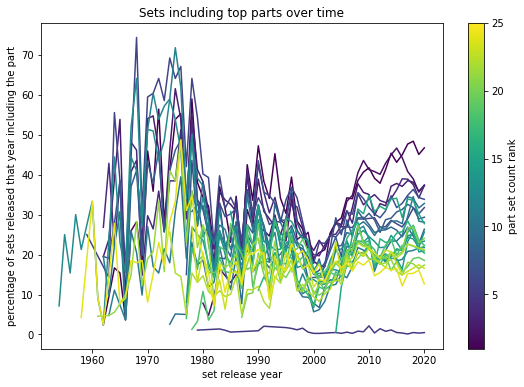

In [31]:
plot_cmap = mpl.cm.viridis
plt.figure(figsize=(9, 6))

for n in range(n_parts):
  plt.plot(top_sbp_years[n], top_sbp_props[n] * 100, c=plot_cmap(n / n_parts))

n_norm = mpl.colors.Normalize(vmin=1, vmax=n_parts)
plt.colorbar(mpl.cm.ScalarMappable(norm=n_norm, cmap=plot_cmap), label='part set count rank')
plt.xlabel('set release year')
plt.ylabel('percentage of sets released that year including the part')
plt.title('Sets including top parts over time')
plt.show()

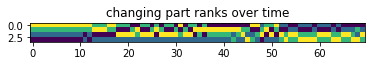

In [32]:
n_years = len(sets_years_distn[0])
n_parts_bump = 4

props_by_year = np.zeros((n_years, n_parts_bump))
for i in range(n_years):
  for n in range(n_parts_bump):
    year = sets_years_distn[0][i]
    if year in top_sbp_years[n]:
      yi = np.where(top_sbp_years[n] == year)
      props_by_year[i][n] = top_sbp_props[n][yi]

ranks_by_year = np.zeros((n_years, n_parts_bump))
for i in range(n_years):
  ranks_by_year[i,:] = np.argsort(props_by_year[i,:])[::-1]

plt.imshow(ranks_by_year.T)
plt.title('changing part ranks over time')
plt.show()

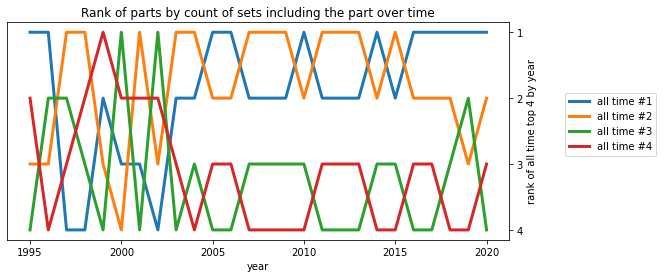

In [33]:
skip_years = 44

fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(111)
ax.plot(n_parts_bump - ranks_by_year[skip_years:,:], lw=3)
ax.set_title('Rank of parts by count of sets including the part over time')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_yticks(np.arange(n_parts_bump) + 1)
ax.set_yticklabels(np.arange(n_parts_bump, 0, -1))
ax.set_ylabel(f'rank of all time top {n_parts_bump} by year')
ax.set_xticks(np.arange(n_years - skip_years)[::5])
ax.set_xticklabels(sets_years_distn[0][skip_years::5])
ax.set_xlabel('year')
ax.legend([f'all time #{r}' for r in range(1, n_parts_bump + 1)],
          bbox_to_anchor=(1.1, 0.7))
plt.show()

# Images

In [34]:
import random

gallery_size = 5
gallery_len = gallery_size ** 2

def trunc_name(name, length):
  if len(name) <= length:
    return name
  snip = (length - 3) // 2
  return name[:snip] + '...' + name[-snip:]

first_single_set_part = len(np.argwhere(part_set_counts > 1))
last_part = len(part_set_counts)
single_set_parts_sample = random.sample(range(first_single_set_part, last_part), gallery_len)

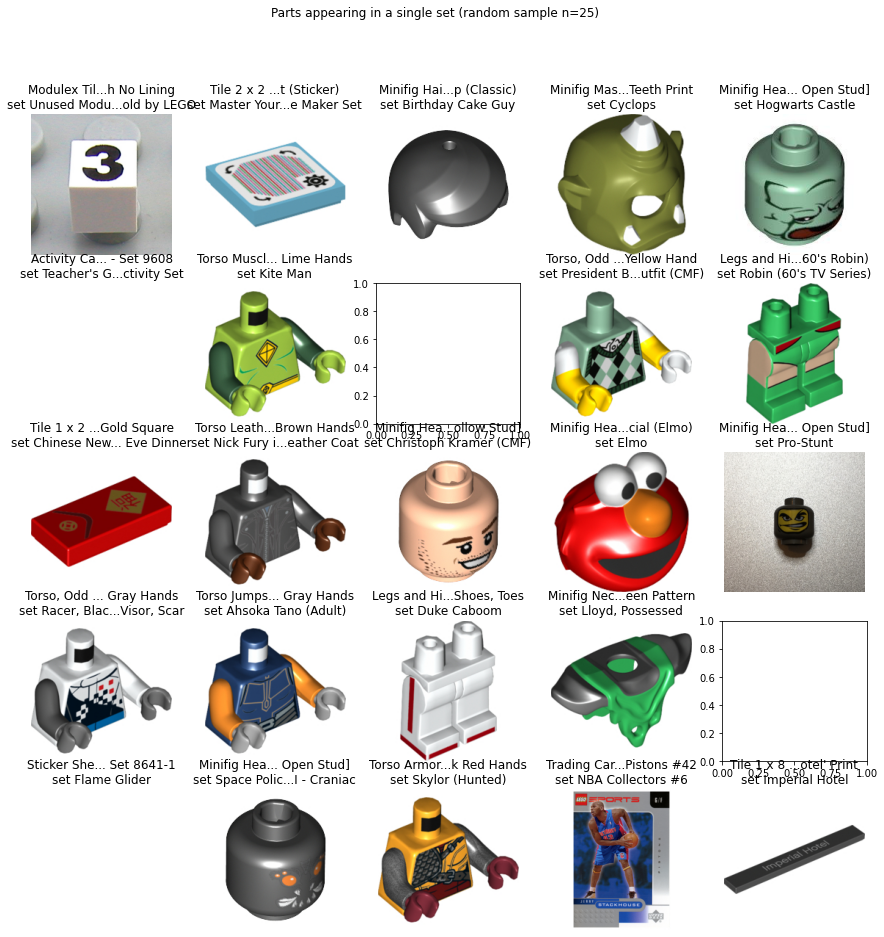

In [35]:
from PIL import Image

fig, ax = plt.subplots(gallery_size, gallery_size)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(gallery_size):
  for j in range(gallery_size):
    n = i * gallery_size + j
    single_set_part = list(counts_sbp_sorted.items())[single_set_parts_sample[n]]
    # occasionally this happens
    if single_set_part[0] not in jcpn.keys():
      continue
    details = jcpn[single_set_part[0]]

    # handle missing images
    img_data = np.ones((10, 10))
    if details['part_img_url'] is not None:
      img_data = Image.open(requests.get(details['part_img_url'], stream=True).raw)

    # handle missing sets
    set_name = 'unknown'
    set_id = list(sets_by_part[single_set_part[0]])[0]
    sets_data = sets_df[sets_df.index == set_id]
    sets_data_minifig = minifigs_df[minifigs_df.index == set_id]
    if len(sets_data) > 0:
      set_name = sets_data['name'][0]
    elif len(sets_data_minifig) > 0:
      set_name = sets_data_minifig['name'][0]
      
    # chart
    ax[i][j].imshow(img_data, cmap='Greys')
    ax[i][j].set_title(f'{trunc_name(details["name"], 25)}\nset {trunc_name(set_name, 25)}')
    ax[i][j].axis('off')

fig.suptitle(f'Parts appearing in a single set (random sample n={gallery_len})')
plt.show()

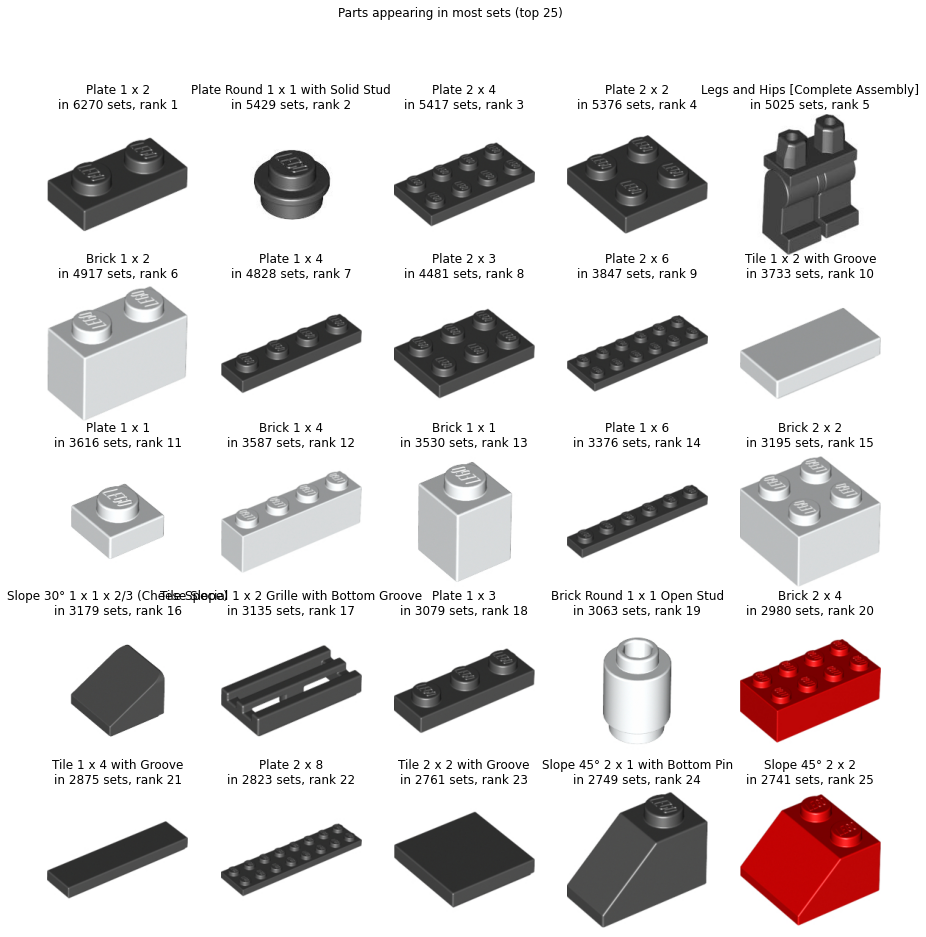

In [36]:
fig, ax = plt.subplots(gallery_size, gallery_size)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(gallery_size):
  for j in range(gallery_size):
    n = i * gallery_size + j
    most_sets_part = list(counts_sbp_sorted.items())[n]
    details = jcpn[most_sets_part[0]]

    ax[i][j].imshow(Image.open(requests.get(details['part_img_url'], stream=True).raw))
    ax[i][j].set_title(f'{details["name"]}\nin {most_sets_part[1]} sets, rank {n + 1}')
    ax[i][j].axis('off')

fig.suptitle(f'Parts appearing in most sets (top {gallery_len})')
plt.show()